In [1]:
import geopandas as gpd
from udtk import geo

import matplotlib.pyplot as plt
%matplotlib inline

/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
#load original data
carto = gpd.read_file('../carto/nyc_parcels.geojson')

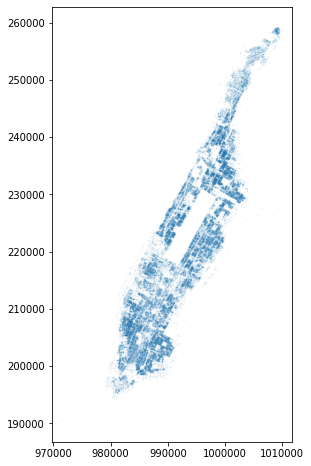

In [3]:
f,ax = plt.subplots(figsize=(8,8))
carto.plot(ax=ax, alpha=0.1,markersize=0.2)

In [4]:
#create grid
grid = geo.hexgrid_from_shapefile(input_shapefile='../carto/nyc_parcels.geojson',
                                  output_shapefile='../carto/grid_8',
                                  res = 8)

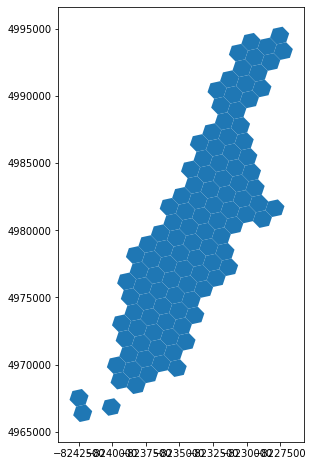

In [5]:
#plot hexgrid data
f,ax = plt.subplots(figsize=(8,8))
grid.plot(ax=ax)

In [6]:
grid.head()

,h3_index,n,geometry
0,882a10085bfffff,2,"POLYGON ((-8231979.536 4991102.167, -8232691.3..."
1,882a100881fffff,290,"POLYGON ((-8234612.577 4983222.344, -8235323.5..."
2,882a100883fffff,962,"POLYGON ((-8234340.000 4982064.997, -8235050.8..."
3,882a100887fffff,102,"POLYGON ((-8235542.610 4982411.218, -8236253.4..."
4,882a100889fffff,533,"POLYGON ((-8233682.332 4984033.499, -8234393.3..."


In [7]:
w = geo.weights_matrix(grid_id_name = 'h3_index',
                       input_shapefile = '../carto/grid_8/grid_8.shp',
                      output_pickle = '../data/w_8.pickle')

/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/lib/weights/contiguity.py:185: UserWarning: There is one disconnected observation (no neighbors).
Island id: 882a1072b9fffff
  W.__init__(self, neighbors, ids=ids, **kw)


In [10]:
cell_id = '882a100883fffff'

In [11]:
w[cell_id]

{'882a100895fffff': 1.0,
 '882a100881fffff': 1.0,
 '882a1008b9fffff': 1.0,
 '882a10088bfffff': 1.0,
 '882a100887fffff': 1.0,
 '882a10089dfffff': 1.0}

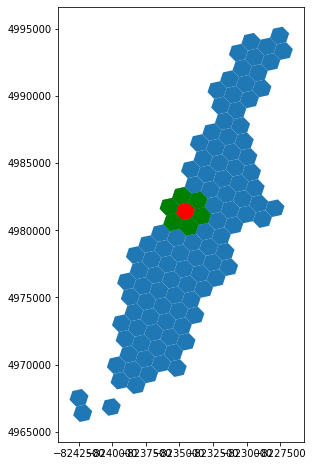

In [15]:
f,ax = plt.subplots(figsize=(8,8))
grid.plot(ax=ax)
grid.loc[grid.h3_index == cell_id].plot(ax=ax,color='red')
grid.loc[grid.h3_index.isin(w[cell_id].keys())].plot(ax=ax,color='green')